### Simple Jupyter Chess 02

Use the "Restart the kernel, then re-run the whole notebook" button or the "Run/Run All Cells" menu option. 

Wait for Board to appear.  
- To make a move, slelect a move in the "Legal Moves" dropdown box and click on "Make Move"
- To play black, click on "Computer Move" for the Computer to make a move.
- To watch the computer play itself, click on "Autoplay". To stop autoplay early, interrupt the kernel.

Engine simply selects randomly from available legal moves.

See end of notebook for additional information.

In [ ]:
# Tons of stuff in one cell for cleaner notebook display.

# Imports

import random
import time

import chess
import chess.svg
import chess.pgn
import ipywidgets as widgets
from ipywidgets import Layout
from rich import print

# Constants

AUTO_PLAY_DELAY = 2
AUTO_PLAY_MOVE_INTERVAL = 10
MOVE_DISPLAY_DELAY = 1

# Initialize Variables

game_over = False

# Define Functions

def random_move(board):
    """
    Selects a move at random from `board.legal_moves` and returns it as a 
    uci string.
    
    Parameters
    ----------
    board: chess.Board object
    
    Returns
    ----------
    : str # as a uci format chess move
    """
    move = random.choice(list(board.legal_moves))
    return move.uci()

def who(player):
    """
    Returns a str "White" or "Black" depending upon `player'.
    
    Parameters
    ----------
    player:  boolean; chess.WHITE = True; chess.BLACK = False.
    
    Returns
    ----------
    : str #  "White" if player == chess.WHITE else "Black" 
    """
    return "White" if player == chess.WHITE else "Black"

def legal_san_moves(board):
    """
    Returns a list of legal moves as strings in san format, sorted alphabetically.
    
    Parameters
    ----------
    board:  chess.Board object
    
    Returns
    ----------
    : list of string literals 
    """
    
    move_list = [board.san(move) for move in board.legal_moves]
    sorted_list = sorted(move_list)
    sorted_list.append('resign')
    return sorted_list

def svg_chess(board, switch=True):
    """
    Uses the python-chess `chess.svg.board()` function to return a rendering 
    of `board` as a svg impage. Whether the board is oriented from the current 
    board.turn POV or kept to the White POV is controlled by the `switch` 
    kwarg.
    
    The returned svg bytestring is suitable for use in `IPython.display.display();`).
    However, it will not work for the `ipywidgets.Image()` widget.  
    
    Parameters
    ----------
    switch: boolean
        if True, will display from the perspective of the player to move. 
        Otherwise, the White POV.
    
    Returns
    -------
        chess.svg.SvgWrapper
    """
    if switch:
        view = board.turn
    else:
        view = chess.WHITE
    
    if len(board.move_stack) > 0:
        move_made = board.move_stack[-1]
    else:
        move_made = None
    
    if board.is_check():
        check_square = board.king(board.turn)
    else:
        check_square = None
        
    return chess.svg.board(
        board, 
        orientation=view,
        lastmove=move_made,
        check=check_square,
        size=400,
    ) 

def todays_date():
    """
    Returns a string for the current date in YYYY.MM.DD format.  
    
    Parameters
    ----------
    
    
    Returns
    -------
        str
    """    
    yr = str(time.localtime(time.time()).tm_year)
    mo = str(time.localtime(time.time()).tm_mon)
    if len(mo) == 1:
        mo = "0"+mo
    day = str(time.localtime(time.time()).tm_mday)
    if len(day) == 1:
        day = "0"+day
    return yr + "." + mo + "."+ day

def refresh_output(output, switch=True):
    """
    Refreshes ipywidgets.Output instance for this notebook.

    Parameters
    ----------
    output: ipywidgets.Output object
    switch: boolean, indicates whether to change board perspective to match that of the current player.
    
    Returns
    -------
        delivers widget output to the output instance of ipywidgets.Output.   
    """
    output.clear_output(wait=True)
    with output:
        display(svg_chess(board, switch))  
        display(moves_widget)
        display(makemove_button)
        display(autoplay_button)
        display(computermove_button)
    return

def player_move(b):
    """
    Call this fuction when makemove_button is clicked.
    """
    
    global board
    global moves_widget
    global game_over
    global output
    
    if moves_widget.value == 'resign':
        game_over = True
    if (not board.is_game_over(claim_draw=True)) and (not game_over):
        board.push_san(moves_widget.value)           # Make the player's move on the Board.
        moves_widget.options=legal_san_moves(board)  # Update moves_widget.
    else:
        game_over = True
    
    if (not board.is_game_over(claim_draw=True)) and (not game_over):
        board.push_uci(random_move(board))           # Make the computers's move on the Board.
        moves_widget.options=legal_san_moves(board)  # Update moves_widget. 
        refresh_output(output)                       # Show the updated board.
    else:
        game_over = True
    
    if (board.is_game_over(claim_draw=True)) or (game_over):
        refresh_output(output, switch=False)
        game_over = True                                     # Tell rest of program game is over.
        with output:
            if board.is_checkmate():
                display("checkmate: " + who(not board.turn) + " wins!")
            elif board.is_stalemate():
                display("draw: stalemate")
            elif board.is_fivefold_repetition():
                display("draw: 5-fold repetition")
            elif board.is_insufficient_material():
                display("draw: insufficient material")
            elif board.can_claim_draw():
                display("draw: claim")
            else:
                display("Player Resigned")

    return

def auto_play(b):
    
    global board
    global moves_widget
    global game_over
    global output
    
    try:
        while not board.is_game_over(claim_draw=True):
            board.push_uci(random_move(board))               # Make a move.
            moves_widget.options=legal_san_moves(board)      # Update moves_widget.
            if board.ply() % AUTO_PLAY_MOVE_INTERVAL == 0:   # Display board every AUTO_PLAY_MOVE_INTERVAL moves.
                refresh_output(output, switch=False)
                time.sleep(AUTO_PLAY_DELAY)
        refresh_output(output)
        game_over = True                                     # Tell rest of program game is over.
        if board.is_checkmate():
            display("checkmate: " + who(not board.turn) + " wins!")
        elif board.is_stalemate():
            display("draw: stalemate")
        elif board.is_fivefold_repetition():
            display("draw: 5-fold repetition")
        elif board.is_insufficient_material():
            display("draw: insufficient material")
        elif board.can_claim_draw():
            display("draw: claim")
        
    except KeyboardInterrupt: 
        output.clear_output(wait=True)
        with output:
            display(svg_chess(board))
            display("Game interrupted!")
        game_over = True                                     # Tell rest of program game is over.
        board

    return

def start_white(b):
    
    global board
    global moves_widget
    global output
   
    board.push_uci(random_move(board))           # Make the computers's move on the Board.
    moves_widget.options=legal_san_moves(board)  # Update moves_widget. 
    refresh_output(output)                       # Show the updated board.
    
    return

# Create output widget.
output = widgets.Output(layout={'border': '1px solid black'})

# Instantiate a chess.Board
board = chess.Board()

# Instantiate ipwidgets
moves_widget = widgets.Dropdown(
    options=legal_san_moves(board),
    description='Legal Moves:',
    # layout=Layout(object_position='right'),
)

autoplay_button = widgets.Button(
    description='Autoplay',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to start autoplay.',
    icon='forward' # (FontAwesome names without the `fa-` prefix)
)

computermove_button = widgets.Button(
    description='Computer Move',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click for a computer move.',
    icon='robot' # (FontAwesome names without the `fa-` prefix)
)

makemove_button = widgets.Button(
    description='Make Move',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to register your move.',
    icon='chess-board' # (FontAwesome names without the `fa-` prefix)
)

# Create output/display area.
output

In [ ]:
# Get date for later use
game_date = todays_date()

# Display the board
output.clear_output(wait=True)
refresh_output(output)

# Start event loops for buttons.
autoplay_button.on_click(auto_play)    # Start auto play upon button click.                      

computermove_button.on_click(start_white) # Make first move for White. 

makemove_button.on_click(player_move)   # Every time a player makes a move, process it.

In [ ]:
# Convert Game Played to pgn
game = chess.pgn.Game.from_board(board)

game.headers["Event"] = "Simple Jupyter Chess Game"
game.headers["Date"] = game_date

print(f"[b black]Rerun this cell to update game output (pgn)[/b black]","\n")
print(f"[black]{game}[black]", "\n")
display(board)

### Notes & Instructions

This notebook is intended to be run via the "Restart the kernel, then re-run the whole notebook" notebook menu button or "Run All Cells" option. 

Users can opt to play white or black vs. a simple chess engine that selects at random from available legal moves, or the program can be set to play itself. See the top of the notebook for button actions.

### Development Notes

This is an adaptation of the notebook project here:
 - https://jupyter.brynmawr.edu/services/public/dblank/CS371%20Cognitive%20Science/2016-Fall/Programming%20a%20Chess%20Player.ipynb
 
Over time, it has evolved away from that notebook, principally in order to implement jupyter widgets for a somwhat more interactive output.

Jopin Talgwin
2022-02-16

#### Setup and installation
 
For now, just copy the file [*later add github clone option...*] into a convenient directory and run it.  The software environment should, at a minimum, 
contain the dependencies shown in chess.yml:

```python
name: chess-39
channels:
  - conda-forge
  - defaults
dependencies:
  - ipywidgets
  - jupyter-server-proxy
  - jupyterlab
  - pip
  - python=3.9
  - rich
  - pip:
    - chess
```

#### Technical/Development information
 
During development of this notebook, a key goal was to make it interactive. For that purpose, [ipywidgets were chosen](https://ipywidgets.readthedocs.io/en/latest/index.html).  

As part of that, the intent was to display the board as a `ipwidgets.Image()` object. The goal of that was to allow better layout control. Ultimately, that was set aside, as while it could be done (see below), it proved slow-ish to update, and led to screen flashing on my machine.  That is why it is currently shown in the output simply as `display(svg_chess(board, switch))` (and, more on this below) rather than something like `display(chessboard_widget)`. Note also, that so far no effort has been made to format the widgets that are in use.

Out of the box, the python-chess package works well in a Jupyter notebook.

For instance:

``` python
import chess
board = chess.Board()
board 
```
Will properly display as:

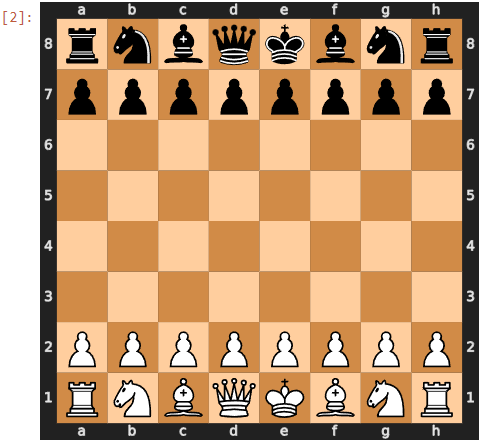

This is because board will by default return a SVG bytestring for display.  And, for instance, `display(board)` will also work.

Also, the `chess.svg.board()` method can be used to control how the SVG is rendered. In the script below, there is a function 
allowing selection of whether the function shows the board from the White or Black side, and to show some highlights on the
board (last move, King in check).

```python
def svg_chess(board, switch=True):
    """
    Uses the python-chess `chess.svg.board()` function to return a rendering 
    of `board` as a svg impage. Whether the board is oriented from the current 
    board.turn POV or kept to the White POV is controlled by the `switch` 
    kwarg.
    
    The returned svg bytestring is suitable for use in `IPython.display.display();`).
    However, it will not work for the `ipywidgets.Image()` widget.  
    
    Parameters
    ----------
    switch: boolean
        if True, will display from the perspective of the player to move. 
        Otherwise, the White POV.
    
    Returns
    -------
        chess.svg.SvgWrapper
    """
    if switch:
        view = board.turn
    else:
        view = chess.WHITE
    
    if len(board.move_stack) > 0:
        move_made = board.move_stack[-1]
    else:
        move_made = None
    
    if board.is_check():
        check_square = board.king(board.turn)
    else:
        check_square = None
        
    return chess.svg.board(
        board, 
        orientation=view,
        lastmove=move_made,
        check=check_square,
        size=400,
    ) 
```

Unfortunately, the svg bytestring returned by `chess.svg.board()` does **not** work as-is for the `ipywidgets.Image()` widget. As noted above, it is possible to make this work (see below), but the resulting display was not satifactory as it was slow, and caused flashing on the screen.

For the record, here is how to make the `chess.svg.board()` output work with the `ipywidgets.Image()` widget.  The solution was found [here](https://github.com/rdkit/rdkit/discussions/3848).

The `svg_chess()` function needs to be modifed (and is renamed here) like so:

```python
def svg_image(board, switch=True):
    """
    Uses the python-chess `chess.svg.board()` function to return a rendering 
    of `board` as a svg impage. Whether the board is oriented from the current 
    board.turn POV or kept to the White POV is controlled by the `switch` 
    kwarg. The returned object is suitable for use in `ipywidgets.Image()`.
    
    Example:

        import chess
        import ipywidgets as widgets
        
        def svg_image(...):
            ....
        
        board_widget = widgets.Image(value=svg_image(board), format = 'svg+xml')
        
    Ref: 
        https://github.com/rdkit/rdkit/discussions/3848
    """
    
    if switch:
        view = board.turn
    else:
        view = chess.WHITE
    
    image = chess.svg.board(
        board, 
        orientation=view,
        size=400,
    ).encode('utf-8') 
    return image  
```

This can then be used as follows:

```python
import chess
import ipywidgets as widgets


board_widget = widgets.Image(
    value=svg_image(board), 
    format = 'svg+xml',
)

# and then

with output:
    display(board_widget) 
    ...  # included other widgets to display here...

```


Jopin Talgwin
2022-02-14